### Imports

In [3]:
import os
import pandas as pd
import csv
import matplotlib.pyplot as plt

### Fetch ADReCs Data

In [4]:
os.makedirs("../raw_data/adrecs", exist_ok=True)

In [5]:
### fetch data from github repo
# !curl -s -H "Accept: application/vnd.github.v3+json" https://api.github.com/repos/zhc940702/MGPred/contents/original_data | jq -r '.[].download_url' | while read url; do wget -P ../raw_data/adrecs "$url"; done


### Load Benchmark Dataset 

In [6]:
# we do end up dropping few se when we drop drug with no valid smiles to generate moelcular graph
se_umls_name_df = pd.read_csv("../raw_data/idse-data/sideeffects.txt", sep="\t", header=None, names=['se_umls_id', 'se_name'])
se_umls_name_df['se_name']  = se_umls_name_df['se_name'].str.lower()
se_umls_name_df.head(3)

,se_umls_id,se_name
0,C0000727,acute abdomen
1,C0000729,abdominal cramps
2,C0000731,abdominal distension


In [7]:
# create mapping to map between side effect uml_id and name
se_uml_id_to_name = dict(se_umls_name_df.values.tolist())
se_uml_name_to_id = {umls_name: umls_id for umls_id, umls_name in se_uml_id_to_name.items()}
print(se_uml_id_to_name)
print(se_uml_name_to_id)

{'C0000727': 'acute abdomen', 'C0000729': 'abdominal cramps', 'C0000731': 'abdominal distension', 'C0000735': 'abdominal neoplasm', 'C0000737': 'abdominal pain', 'C0000768': 'congenital anomaly', 'C0000772': 'multiple congenital abnormalities', 'C0000786': 'abortion spontaneous', 'C0000814': 'abortion missed', 'C0000832': 'premature separation of placenta', 'C0000833': 'abscess', 'C0000889': 'acanthosis nigricans', 'C0000924': 'accident', 'C0000932': 'traffic accident', 'C0001122': 'acidosis', 'C0001125': 'lactic acidosis', 'C0001126': 'renal tubular acidosis', 'C0001127': 'respiratory acidosis', 'C0001175': 'acquired immunodeficiency syndrome', 'C0001198': 'acrodynia', 'C0001206': 'acromegaly', 'C0001231': 'ectopic acth syndrome', 'C0001339': 'pancreatitis acute', 'C0001349': 'acute phase reaction', 'C0001361': 'acute tonsillitis', 'C0001364': 'acute yellow liver atrophy', 'C0001396': 'adams-stokes syndrome', 'C0001403': "addison's disease", 'C0001416': 'adenitis', 'C0001418': 'adenoc

In [8]:
AllSideEffectName = se_umls_name_df['se_name'].tolist() # we still drop few side effects when we drop drugs wit no molecualr graph
AllSideEffectName[:4]

['acute abdomen',
 'abdominal cramps',
 'abdominal distension',
 'abdominal neoplasm']

### Define Utility read write csv/xlsx files

In [9]:
def ReadMyCsv(SaveList, fileName):
    csv_reader = csv.reader(open(fileName))
    for row in csv_reader:
        SaveList.append(row)
    return

def StorFile(data, fileName):
    with open(fileName, "w", newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data)
    return

### Read ADRECs 

In [10]:
adrec_df = pd.read_excel('../raw_data/adrecs/ADR_Drug.xlsx', header=None, names=['_', '_', 'mesh_id', 'se_name'])
adrec_df = adrec_df[['se_name', 'mesh_id']]
adrec_df.head(1)

,se_name,mesh_id
0,5'nucleotidase increased,13.03.01.036


In [11]:
# standardize mesh_id by introducing a in the beginning and making all segement between . as 3 digit with leading 0
standardize_adrec = lambda y: '.'.join(['a' + y.split('.')[0]] + [segment.zfill(3) for segment in y.split('.')[1:]])

In [12]:
# standardize mesh id 
adrec_df['mesh_id'] = adrec_df['mesh_id'].apply(standardize_adrec)
adrec_df.head(1)

,se_name,mesh_id
0,5'nucleotidase increased,a13.003.001.036


In [13]:
mesh = adrec_df.values.tolist() # se_name to mesh_id one to one map to be used to find ancenstors
mesh[:17]

[["5'nucleotidase increased", 'a13.003.001.036'],
 ['abasia', 'a17.002.005.035'],
 ['abasia', 'a08.001.002.007'],
 ['abdominal abscess', 'a11.001.007.006'],
 ['abdominal abscess', 'a07.019.002.002'],
 ['abdominal adhesions', 'a12.002.003.006'],
 ['abdominal adhesions', 'a07.007.003.001'],
 ['abdominal and gastrointestinal infections', 'a11.001.007'],
 ['abdominal cramp', 'a07.001.005.001'],
 ['abdominal discomfort', 'a07.001.006.001'],
 ['abdominal distension', 'a07.001.004.001'],
 ['abdominal distress', 'a07.001.006.013'],
 ['abdominal findings abnormal', 'a07.001.001'],
 ['abdominal hernia', 'a07.016.006.005'],
 ['abdominal hernias and other abdominal wall conditions', 'a07.016'],
 ['abdominal hernias nec', 'a07.016.006'],
 ['abdominal infection', 'a11.001.007.014']]

In [14]:
adrec_df.shape

(9322, 2)

### Get all mesh id for each side_effect

In [15]:
# adrec_df = adrec_df[adrec_df['SeName'].isin(AllSideEffectName)]

In [16]:
adrec_mesh_id_df = adrec_df.groupby('se_name')['mesh_id'].apply(list).reset_index()
# adrec_mesh_id_df['layer'] = 0
adrec_mesh_id_df.head(1)

,se_name,mesh_id
0,5'nucleotidase increased,[a13.003.001.036]


In [17]:
adrec_mesh_id_df.shape

(6617, 2)

In [18]:
SeNameAndMeshID = adrec_mesh_id_df.values.tolist()

In [19]:
# no sense to introduce se with no matching adrecs
# SeNameAndMeshID = [[se_name, adrec_mesh_id_df.get(se_name, 0)] for se_name in AllSideEffectName]

In [20]:
SeNameAndMeshID[:3]

[["5'nucleotidase increased", ['a13.003.001.036']],
 ['abasia', ['a17.002.005.035', 'a08.001.002.007']],
 ['abdominal abscess', ['a11.001.007.006', 'a07.019.002.002']]]

In [21]:
print(len(SeNameAndMeshID))
print(SeNameAndMeshID[-3:])

6617
[['zinc deficiency', ['a14.013.001.001']], ['zinc disorders', ['a14.013.001']], ['zygomycosis', ['a07.005.007.012', 'a17.006.009.004', 'a22.007.003.022', 'a11.003.005.013']]]


In [22]:
side_effect_all_mesh_id_map = dict(SeNameAndMeshID)

### Create DAGs leaf element for each side_effect using Allside_effect

In [23]:
DAGs = [[se_name_and_mesh_id+[0]] for se_name_and_mesh_id in SeNameAndMeshID]

In [24]:
DAGs[-3:]

[[['zinc deficiency', ['a14.013.001.001'], 0]],
 [['zinc disorders', ['a14.013.001'], 0]],
 [['zygomycosis',
   ['a07.005.007.012',
    'a17.006.009.004',
    'a22.007.003.022',
    'a11.003.005.013'],
   0]]]

In [25]:
mesh[:4]

[["5'nucleotidase increased", 'a13.003.001.036'],
 ['abasia', 'a17.002.005.035'],
 ['abasia', 'a08.001.002.007'],
 ['abdominal abscess', 'a11.001.007.006']]

### Find ancestors and create set of nodes of ancestor for each side_effect

In [26]:
import collections

def process_dags(DAGs, side_effect_id_map, mesh, filename='../prep_data/adrecs/adrec_prep_DAG.csv'):
    DAGs_with_ancestors_all = []

    for DAG in DAGs:
        if DAG[0][1] == 0:  # If no leaf found
            DAGs_with_ancestors_all.append(DAG)
        else:
            # Process DAGs with leaves
            DAGs_with_ancestors = [DAG[0]]  # Initialize with the first node
            
            for i, (side_effect_name, ancestors_id_list, layer) in enumerate(DAGs_with_ancestors):
                for syn_se in ancestors_id_list:
                    if len(syn_se) > 3:  # If there's anything after 'a17.'
                        NID = syn_se[:-4]  # All except last 3 characters
                        for se_mesh in mesh:
                            if NID == se_mesh[1]:
                                parent_side_effect = se_mesh[0]
                                if parent_side_effect not in [node[0] for node in DAGs_with_ancestors]:
                                    # Add parent side_effect with its IDs and incremented layer
                                    DAGs_with_ancestors.append([
                                        parent_side_effect,
                                        side_effect_id_map[parent_side_effect],
                                        layer + 1
                                    ])
                
            DAGs_with_ancestors_all.append(DAGs_with_ancestors)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    StorFile(DAGs_with_ancestors_all, filename) # no need to save as csv file
    return DAGs_with_ancestors_all

In [27]:
DAGs_with_ancestors_all = process_dags(DAGs, side_effect_all_mesh_id_map, mesh)

In [28]:
DAGs_with_ancestors_all[-3:]

[[['zinc deficiency', ['a14.013.001.001'], 0],
  ['zinc disorders', ['a14.013.001'], 1],
  ['iron and trace metal metabolism disorders', ['a14.013'], 2],
  ['metabolism and nutrition disorders', ['a14'], 3]],
 [['zinc disorders', ['a14.013.001'], 0],
  ['iron and trace metal metabolism disorders', ['a14.013'], 1],
  ['metabolism and nutrition disorders', ['a14'], 2]],
 [['zygomycosis',
   ['a07.005.007.012',
    'a17.006.009.004',
    'a22.007.003.022',
    'a11.003.005.013'],
   0],
  ['oral soft tissue infections', ['a07.005.007'], 1],
  ['nervous system infections nec', ['a17.006.009'], 1],
  ['upper respiratory tract infections nec', ['a22.007.003'], 1],
  ['fungal infections nec', ['a11.003.005'], 1],
  ['oral soft tissue conditions', ['a07.005'], 2],
  ['central nervous system infections and inflammations', ['a17.006'], 2],
  ['respiratory tract infections', ['a22.007'], 2],
  ['fungal infectious disorders', ['a11.003'], 2],
  ['gastrointestinal disorders', ['a07'], 3],
  ['nervo

In [29]:
DAGs_with_ancestors_all[[_[0] for _ in SeNameAndMeshID].index('cerebral artery stenosis')]

[['cerebral artery stenosis', ['a17.008.002.010', 'a24.004.006.023'], 0],
 ['central nervous system vascular disorders nec', ['a17.008.002'], 1],
 ['cerebrovascular and spinal necrosis and vascular insufficiency',
  ['a24.004.006'],
  1],
 ['central nervous system vascular disorders', ['a17.008'], 2],
 ['arteriosclerosis, stenosis, vascular insufficiency and necrosis',
  ['a24.004'],
  2],
 ['nervous system disorders', ['a17'], 3],
 ['vascular disorders', ['a24'], 3]]

### Load processed DAGs with ancestors id

In [30]:
# load DAGs 
DAGs_with_ancestors_all = []
ReadMyCsv(DAGs_with_ancestors_all, '../prep_data/adrecs/adrec_prep_DAG.csv')
DAGs_with_ancestors_all = [[eval(node) for node in dag] for dag in DAGs_with_ancestors_all]  #Quick fix with data types if loaded from prep_data
print(len(DAGs_with_ancestors_all))
print(DAGs_with_ancestors_all[0])


6617
[["5'nucleotidase increased", ['a13.003.001.036'], 0], ['liver function analyses', ['a13.003.001'], 1], ['hepatobiliary investigations', ['a13.003'], 2], ['investigations', ['a13'], 3]]


### Calculate Side effect semantic value using ancenstors collected in DAGs 

In [31]:
import numpy as np
from multiprocessing import Pool
import os

def calculate_se_semantic_value(DAGs_with_ancestors_all, filename="../prep_data/adrecs/se_semantic_values.csv"):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    se_semantic_values = []
    for dag in DAGs_with_ancestors_all:
        if dag[0][1] == 0:
            se_semantic_values.append([dag[0][0], 0])
        else:
            semantic_val = np.sum(0.5 ** np.array([node[2] for node in dag]))
            se_semantic_values.append([dag[0][0], semantic_val])
    print(f"Length of Se_Semantic_values {len(se_semantic_values)}")
    # Convert to numpy array
    se_semantic_values = np.array(se_semantic_values, dtype=object)
    
    # Save to file
    np.savetxt(filename, se_semantic_values, delimiter=',', fmt=['%s', '%.18e'])
    return np.array(se_semantic_values)


In [32]:
se_semantic_values = calculate_se_semantic_value(DAGs_with_ancestors_all)

Length of Se_Semantic_values 6617


In [33]:
se_semantic_values[:2]

array([["5'nucleotidase increased", 1.875],
       ['abasia', 2.75]], dtype=object)

### Compute Side effect similarity

#### Common/ Same Value

In [34]:
def calculate_similarity(i, DAGs, se_semantic_values):
    row_values = np.zeros(len(DAGs))
    if se_semantic_values[i, 1] == 0:
        return row_values
    for j in range(i, len(DAGs)):
        if se_semantic_values[j, 1] == 0:
            continue
        similarity = sum(
            0.5 ** node1[2] + 0.5 ** node2[2]
            for node1 in DAGs[i]
            for node2 in DAGs[j]
            if node1[0] == node2[0]
        )
        row_values[j] = similarity
    return row_values

def calculate_similarity_matrix(DAGs, se_semantic_values, filename="../prep_data/adrecs/se_samevalue.csv"):
    with Pool() as pool:
        similarity_matrix = pool.starmap(
            calculate_similarity,
            [(i, DAGs, se_semantic_values) for i in range(len(DAGs))]
        )
    similarity_matrix = np.array(similarity_matrix)
    similarity_matrix = similarity_matrix + similarity_matrix.T - np.diag(np.diag(similarity_matrix))
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    np.savetxt(filename, similarity_matrix, delimiter=',')
    print('SE_Samevalue calculated and saved')
    return similarity_matrix

In [35]:
similarity_matrix = calculate_similarity_matrix(DAGs_with_ancestors_all, se_semantic_values)

SE_Samevalue calculated and saved


#### Final SE Semantica similarity using common|intersection / union 

In [36]:
def filter_similarity_model(similarity_model, DAGs_with_ancestors_all, AllSideEffectName):
    # Create a mapping of se_name to index
    se_name_to_index = {dag[0][0]: i for i, dag in enumerate(DAGs_with_ancestors_all)}
    
    # Get indices of side effects in AllSideEffectName
    valid_indices = [se_name_to_index[se_name] for se_name in AllSideEffectName if se_name in se_name_to_index]
    filtered_se = [dag[0][0] for dag in np.array(DAGs_with_ancestors_all, dtype='object')[valid_indices]]
    # Filter the similarity model
    filtered_similarity_model = similarity_model[np.ix_(valid_indices, valid_indices)]
    
    return filtered_similarity_model, filtered_se

def calculate_similarity_model(se_semantic_values, SameValue1, DAGs_with_ancestors_all, AllSideEffectName, filename="../prep_data/adrecs/similarity_model.csv"):
    # Convert inputs to NumPy arrays for faster operations
    side_effect_values = np.array([se[1] for se in se_semantic_values])
    # SameValue1 = np.array(SameValue1)

    # Create a mask for zero values
    zero_mask = side_effect_values == 0

    # Calculate the denominator for non-zero values
    denominator = side_effect_values[:, np.newaxis] + side_effect_values[np.newaxis, :]
    
    # Calculate the similarity model
    similarity_model = np.zeros_like(SameValue1, dtype=float)
    non_zero_mask = ~zero_mask[:, np.newaxis] & ~zero_mask[np.newaxis, :]
    similarity_model[non_zero_mask] = SameValue1[non_zero_mask] / denominator[non_zero_mask]
    
    # Set diagonal elements to 0
    np.fill_diagonal(similarity_model, 0)

    print(f'side_effectSimilarityModel1: {similarity_model.shape}')
    print(f'side_effectSimilarityModel1[0]: {similarity_model[0].shape}')

    # Usage
    filtered_side_effectSimilarityModel1, se_name = filter_similarity_model(similarity_model, DAGs_with_ancestors_all, AllSideEffectName)
    print(f'filter_side_effectSimilarityModel1: {filtered_side_effectSimilarityModel1.shape}')
    print(f'filter_side_effectSimilarityModel1[0]: {filtered_side_effectSimilarityModel1[0].shape}')
    # create df with AllSideEffectName as index and columns and filtered_side_effectSimilarityModel1 as values
    df = pd.DataFrame(filtered_side_effectSimilarityModel1, index=se_name, columns=se_name)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    # Save to file
    df.to_csv(filename, index=True, index_label=False)
    print(f'Similarity model saved to {filename}')
    return df

In [37]:
side_effectSimilarityModel = calculate_similarity_model(se_semantic_values, similarity_matrix, DAGs_with_ancestors_all, AllSideEffectName)

side_effectSimilarityModel1: (6617, 6617)
side_effectSimilarityModel1[0]: (6617,)
filter_side_effectSimilarityModel1: (3565, 3565)
filter_side_effectSimilarityModel1[0]: (3565,)
Similarity model saved to ../prep_data/adrecs/similarity_model.csv


In [38]:
side_effectSimilarityModel

,acute abdomen,abdominal distension,abdominal neoplasm,abdominal pain,congenital anomaly,multiple congenital abnormalities,abortion spontaneous,abortion missed,abscess,acanthosis nigricans,...,hiatus hernia,peripheral artery stenosis,lacrimal structural disorder,accidental exposure to product,visual impairment,food intolerance,abnormal vision,neutrophilia,deafness bilateral,blood calcium decreased
acute abdomen,0.000000,0.200000,0.054054,0.200000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.054054,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
abdominal distension,0.200000,0.000000,0.054054,0.200000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.054054,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
abdominal neoplasm,0.054054,0.054054,0.000000,0.054054,0.0,0.000000,0.0,0.0,0.0,0.045455,...,0.045455,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
abdominal pain,0.200000,0.200000,0.054054,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.054054,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
congenital anomaly,0.000000,0.000000,0.000000,0.000000,0.0,0.466667,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
food intolerance,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
abnormal vision,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.066667,0.0,0.466667,0.0,0.0,0.0,0.0,0.0
neutrophilia,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
deafness bilateral,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


### Similarity above threshold

In [39]:
import pandas as pd

df = pd.read_csv("../prep_data/adrecs/similarity_model.csv")
df.head(1)

,acute abdomen,abdominal distension,abdominal neoplasm,abdominal pain,congenital anomaly,multiple congenital abnormalities,abortion spontaneous,abortion missed,abscess,acanthosis nigricans,...,hiatus hernia,peripheral artery stenosis,lacrimal structural disorder,accidental exposure to product,visual impairment,food intolerance,abnormal vision,neutrophilia,deafness bilateral,blood calcium decreased
acute abdomen,0.0,0.2,0.054054,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.054054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
df.loc['acute abdomen'].values.max(), df.loc['acute abdomen'].values.min()

(0.4666666666666667, 0.0)

Number of pairs with similarity above 0.3: 20935/6352830
Percentage above threshold_similarity 0.3: 0.33%


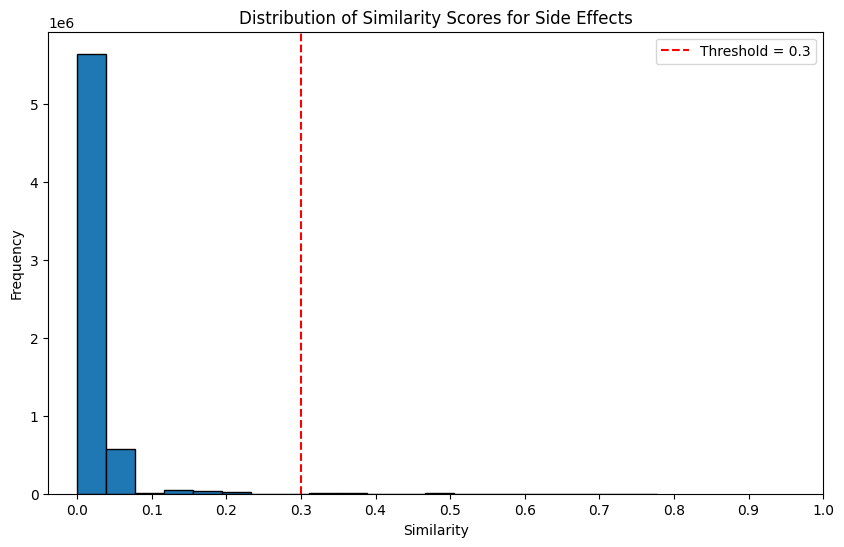

In [41]:
# Extract upper triangle of the similarity matrix, excluding the diagonal
upper_triangle_indices = np.triu_indices_from(df.values, k=1)
similarity_scores = df.values[upper_triangle_indices]

# Create a DataFrame of the similarity scores
similarity_scores_df = pd.DataFrame(similarity_scores, columns=['Similarity'])

# Define the threshold
threshold_similarity = 0.3  # You can adjust this as needed

# Count pairs above the threshold
count_above_threshold = (similarity_scores_df['Similarity'] > threshold_similarity).sum()
total_pairs = similarity_scores_df.shape[0]

print(f'Number of pairs with similarity above {threshold_similarity}: {count_above_threshold}/{total_pairs}')
print(f'Percentage above threshold_similarity {threshold_similarity}: {count_above_threshold/total_pairs:.2%}')

# Plotting
plt.figure(figsize=(10, 6))

# Determine an appropriate number of bins dynamically
num_bins = 20  # Adjust based on your preference or data

# Plot histogram with dynamic bin size
plt.hist(similarity_scores_df['Similarity'], bins=num_bins, edgecolor='black')

# Set x-axis ticks to be in increments of 0.1
plt.xticks(np.arange(0, 1.1, 0.1))

plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores for Side Effects')

# Plot vertical line at the threshold
plt.axvline(x=threshold_similarity, color='r', linestyle='--', label=f'Threshold = {threshold_similarity}')

# Add legend
plt.legend()

# Show plot
plt.show()

### Edge above threshold

In [42]:
similarity_scores_df.head()

,Similarity
0,0.200000
1,0.054054
2,0.200000
3,0.000000
4,0.000000


In [43]:
threshold_similarity

0.3

In [44]:
# Extract drug IDs for the corresponding indices
se_ids = df.index

# Initialize lists to store results
se_name_emb_pairs = []
se_name_emb_pairs_attr = []

# Define the similarity threshold
se_name_thresh = threshold_similarity

# Filter and collect pairs above the threshold
for index, sim in enumerate(similarity_scores):
    if sim > se_name_thresh:
        i, j = upper_triangle_indices[0][index], upper_triangle_indices[1][index]
        se_name_emb_pairs.append([se_ids[i], se_ids[j]])
        se_name_emb_pairs_attr.append(sim)

# Convert results to DataFrame
se_name_sim_df = pd.DataFrame({
    'SE Pair': se_name_emb_pairs,
    'Similarity': se_name_emb_pairs_attr
})

# Output the number of pairs and a sample of the pairs
print(f'Number of SE pairs with similarity above {se_name_thresh}: {len(se_name_emb_pairs)}')
print('Sample pairs:', se_name_emb_pairs[:5])
se_name_sim_df.head()

Number of SE pairs with similarity above 0.3: 20935
Sample pairs: [['acute abdomen', 'bruxism'], ['acute abdomen', 'dysphagia'], ['acute abdomen', 'faecal incontinence'], ['acute abdomen', 'breath odour'], ['acute abdomen', 'hiccups']]


,SE Pair,Similarity
0,"[acute abdomen, bruxism]",0.378378
1,"[acute abdomen, dysphagia]",0.466667
2,"[acute abdomen, faecal incontinence]",0.378378
3,"[acute abdomen, breath odour]",0.466667
4,"[acute abdomen, hiccups]",0.378378


In [45]:
def edge_name_to_id(edge_list, map_dict):
    return [(map_dict[edge[0]], map_dict[edge[1]]) for edge in edge_list]

In [46]:
se_name_emb_pairs_id = edge_name_to_id(se_name_emb_pairs, se_uml_name_to_id)

In [47]:
se_name_emb_pairs_id

[('C0000727', 'C0006325'),
 ('C0000727', 'C0011168'),
 ('C0000727', 'C0015732'),
 ('C0000727', 'C0018520'),
 ('C0000727', 'C0019521'),
 ('C0000727', 'C0020505'),
 ('C0000727', 'C0021167'),
 ('C0000727', 'C0030794'),
 ('C0000727', 'C0221470'),
 ('C0000727', 'C0232487'),
 ('C0000727', 'C0235295'),
 ('C0000727', 'C0239233'),
 ('C0000727', 'C0239571'),
 ('C0000727', 'C0740651'),
 ('C0000727', 'C0854372'),
 ('C0000727', 'C1096250'),
 ('C0000727', 'C1112565'),
 ('C0000727', 'C1504561'),
 ('C0000727', 'C1535975'),
 ('C0000727', 'C1868919'),
 ('C0000731', 'C0001707'),
 ('C0000731', 'C0016204'),
 ('C0000731', 'C0858217'),
 ('C0000735', 'C0017185'),
 ('C0000735', 'C0027651'),
 ('C0000735', 'C0030793'),
 ('C0000735', 'C0238198'),
 ('C0000735', 'C0521158'),
 ('C0000737', 'C0159066'),
 ('C0000737', 'C0221727'),
 ('C0000737', 'C0232492'),
 ('C0000737', 'C0232495'),
 ('C0000737', 'C0232498'),
 ('C0000737', 'C0344375'),
 ('C0000737', 'C0687713'),
 ('C0000737', 'C0877617'),
 ('C0000737', 'C0877664'),
 